In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array
from numpy import hstack

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [ ]:
train_sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')

## train_sales
* id: validation id
* item_id: item id
* cat_id: category (ex. hobbies, household, foods)
* store_id: from which store
* state_id: in which state(ex. CA, TX, WI)

In [ ]:
train_sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


## sell_price
* sell_price: price for the item in the week

In [ ]:
sell_prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


## calender
* event_name: special day(ex. SuperBowl)
* snap: The Supplemental Nutrition Assistance Program

In [ ]:
calendar.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


# EDA

* observe sales at the scale of ***state***
    * California generally has better salls than the other two states.
    * Apart from **foods** Texas is better than Wisconsin
    * The total sales of the category is: Foods > household > hobbies

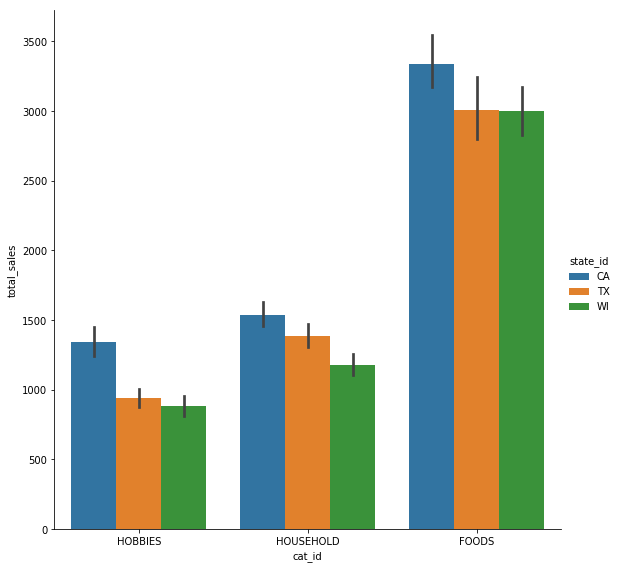

In [ ]:
train_sales['total_sales'] = train_sales.sum(axis=1)
sns.catplot(x="cat_id", y="total_sales",
                hue="state_id",
                data=train_sales, kind="bar",
                height=8, aspect=1);

Below is the population of California, Texas, and Wisconsin. As you can see the order of population is the same as sales. (CA > TX > WI)<br/>
Eventhough the orders are the same, the difference gaps of sales between each state are not the same. For example, the population of Wisconsin is only 12.5% of California and 17% of Texas. But the sales of Wisconsin is only a bit less than the other states. <br/>
So, maybe obersveing at the scale of state is not good enough.<br/>
Next, we will look at the problem at a smaller scale<br/>

## At the scale of stores


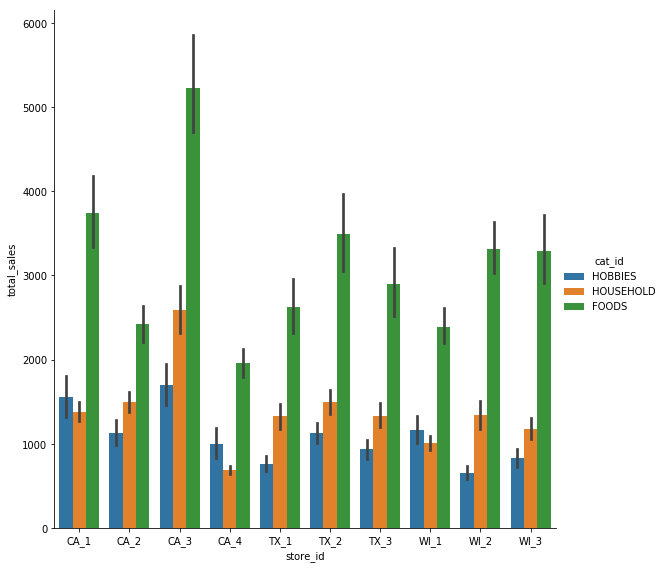

In [ ]:
sns.catplot(x="store_id", y="total_sales",
                hue="cat_id",
                data=train_sales, kind="bar",
                height=8, aspect=1);

## Perspective of Time

In [ ]:
hobbies_state = train_sales.loc[(train_sales['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T
hobbies_state = hobbies_state.rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1)
household_state = train_sales.loc[(train_sales['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T
household_state = household_state.rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1)
foods_state = train_sales.loc[(train_sales['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T
foods_state = foods_state.rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1)
nine_example = pd.concat([hobbies_state, household_state, foods_state], axis=1)
nine_example = nine_example.drop('total_sales')

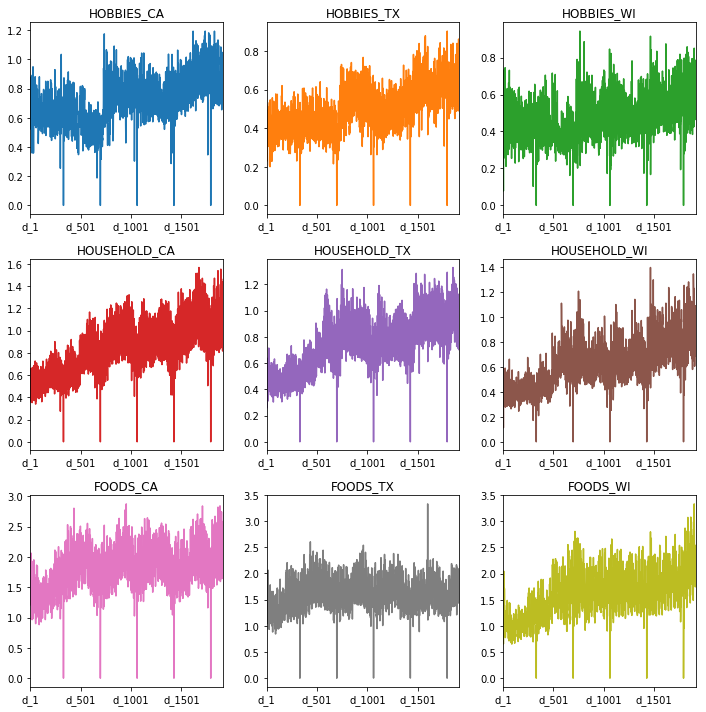

In [ ]:
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(3,3, figsize=(10,10))
axs = axs.flatten()
ax_idx = 0
for item in nine_example.columns:
    nine_example[item].plot(title=item, color=next(color_cycle), ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

As you can see in the following parts, these results are costed by annual events. Like the 0 sales days I just mentioned are cost by Christmas. In the given data sets there are a lot of annual events, some have effects on the sales , and some do not.

In [ ]:
nine_example.loc[nine_example['HOBBIES_CA'] == 0]

state_id,HOBBIES_CA,HOBBIES_TX,HOBBIES_WI,HOUSEHOLD_CA,HOUSEHOLD_TX,HOUSEHOLD_WI,FOODS_CA,FOODS_TX,FOODS_WI
d_331,0.0,0.0,0.0,0.0,0.0,0.000000,0.001392,0.000464,0.000696
d_697,0.0,0.0,0.0,0.0,0.0,0.000000,0.001044,0.000464,0.000696
d_1062,0.0,0.0,0.0,0.0,0.0,0.000000,0.000870,0.003016,0.000464
d_1427,0.0,0.0,0.0,0.0,0.0,0.000000,0.001044,0.003016,0.000232
d_1792,0.0,0.0,0.0,0.0,0.0,0.000318,0.001044,0.000928,0.000696


In [ ]:
calendar.loc[calendar['d'].isin(['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792'])]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


## Other special events
Since special events like Christmas affects the sales in every state, perhaps there are other events that also make the sales go lower or higher nationally. In file "calendar", there are 30 differert events. Including Superbowl, Valentines day, Presidents day, etc.<br/>
Below, shows the stores mean sales in **HOBBIES** of each states, and points out the spacial events. It is pretty obvious that tehre are some events always appear in the same place compare to the sales trend. For instance, there are always two points beside the Christmas points(those equal to 0). Latter there is a clearer graph to show this.

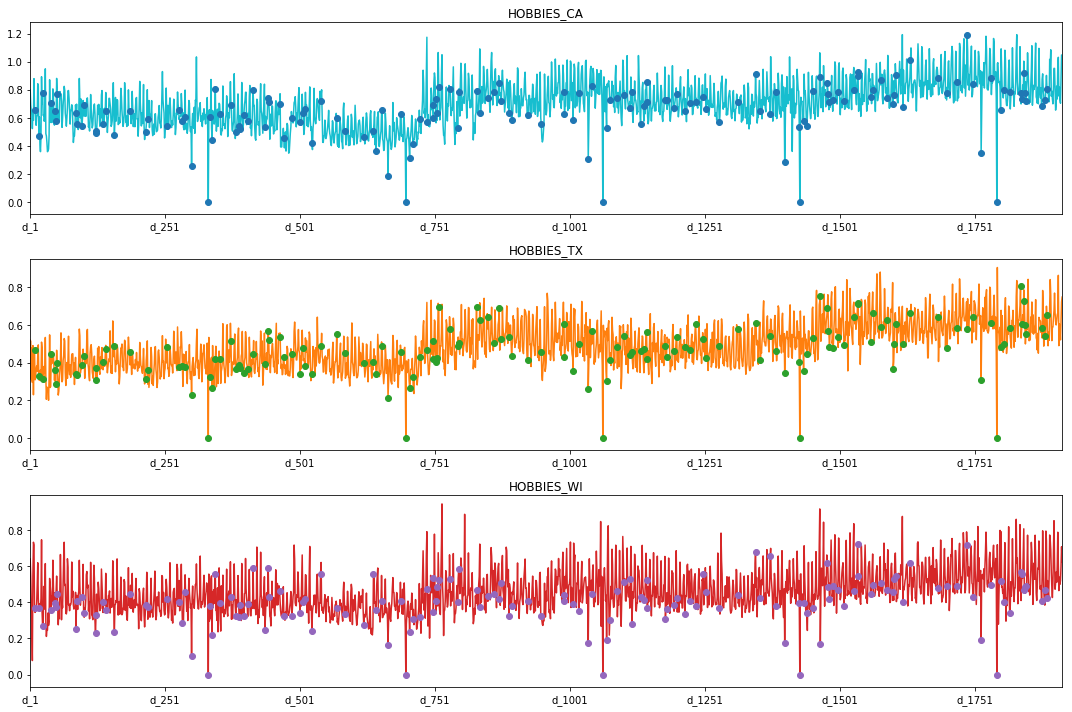

In [ ]:
event_date = calendar.loc[calendar['event_name_1'].isin(calendar.event_name_1.unique()[1:])].d
HOBBIES_event = train_sales.loc[(train_sales['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T.reset_index()
HOBBIES_event = HOBBIES_event.loc[HOBBIES_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['HOBBIES_CA'].plot(title='HOBBIES_CA', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['HOBBIES_TX'].plot(title='HOBBIES_TX', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['HOBBIES_WI'].plot(title='HOBBIES_WI', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

Here is the clearer graph, ss you can see "Thanksgiving", "Christmas", and "NewYear" always appear in the bottom of the trend in every year and every state. While there are events with patterns, there are also many hug events without patterns. In the graph, point "SuperBowl" appears on different sides of the trend. Sometimes it's at the top, but sometimes it's at the bottom. So, in prediction events like SuperBowl should not be taken into account.


![](https://i.imgur.com/OlTQtrf.png)

## Inspect the data at different time scale

In [ ]:
cal = calendar[['d', 'wday', 'month', 'year']]
cal = cal.rename(columns={'d': 'index'})
hobbies_state = train_sales.loc[(train_sales['cat_id'] == 'HOBBIES')].groupby(['state_id']).sum().T
hobbies_state = hobbies_state.reset_index()
hobbies_state = pd.merge(hobbies_state,cal, on='index')
household_state = train_sales.loc[(train_sales['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).sum().T
household_state = household_state.reset_index()
household_state = pd.merge(household_state,cal, on='index')
foods_state = train_sales.loc[(train_sales['cat_id'] == 'FOODS')].groupby(['state_id']).sum().T
foods_state = foods_state.reset_index()
foods_state = pd.merge(foods_state,cal, on='index')

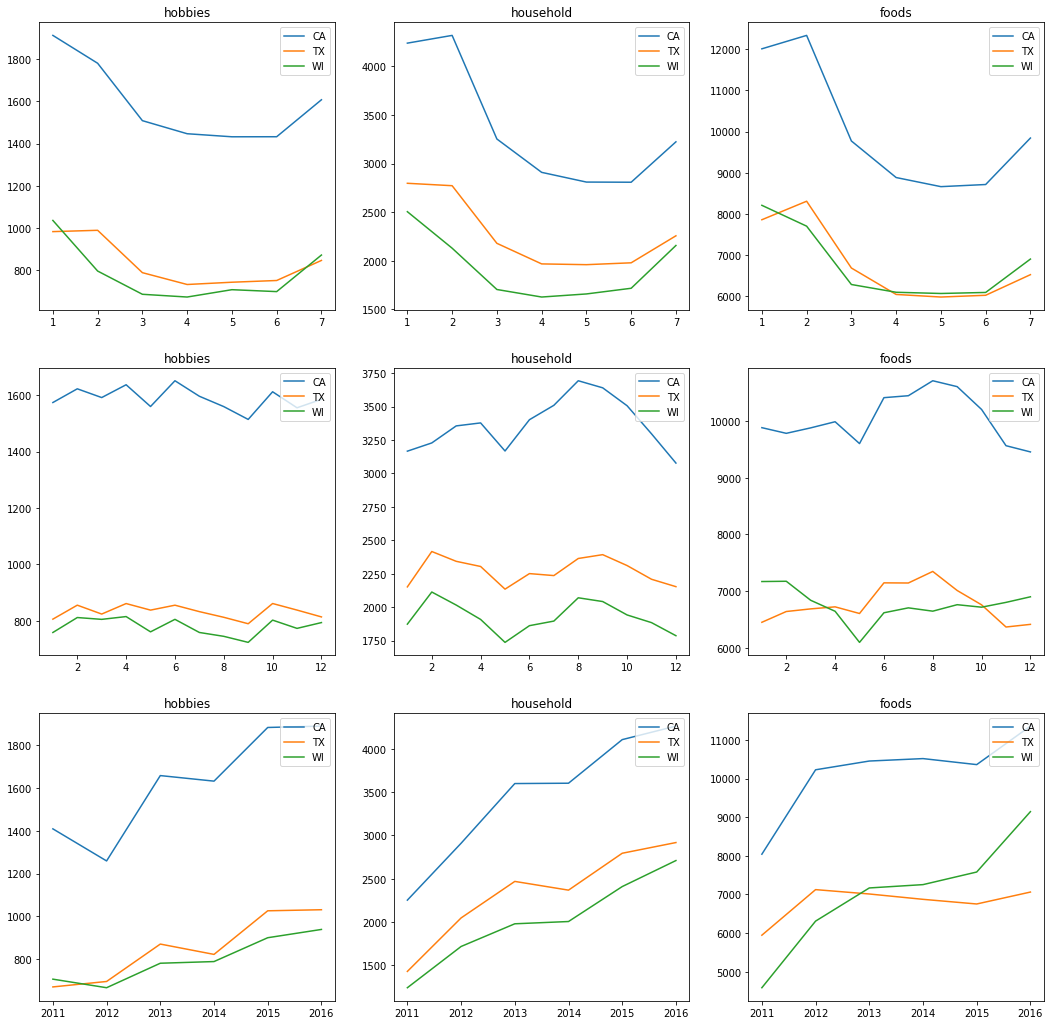

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(3,3,1)
plt.title('hobbies')
plt.plot(range(1, 7 + 1 ,1), hobbies_state.groupby(['wday']).mean().CA, label='CA')
plt.plot(range(1, 7 + 1 ,1), hobbies_state.groupby(['wday']).mean().TX, label='TX')
plt.plot(range(1, 7 + 1 ,1), hobbies_state.groupby(['wday']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,2)
plt.title('household')
plt.plot(range(1, 7 + 1 ,1), household_state.groupby(['wday']).mean().CA, label='CA')
plt.plot(range(1, 7 + 1 ,1), household_state.groupby(['wday']).mean().TX, label='TX')
plt.plot(range(1, 7 + 1 ,1), household_state.groupby(['wday']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,3)
plt.title('foods')
plt.plot(range(1, 7 + 1 ,1), foods_state.groupby(['wday']).mean().CA, label='CA')
plt.plot(range(1, 7 + 1 ,1), foods_state.groupby(['wday']).mean().TX, label='TX')
plt.plot(range(1, 7 + 1 ,1), foods_state.groupby(['wday']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,4)
plt.title('hobbies')
plt.plot(range(1, 12 + 1 ,1), hobbies_state.groupby(['month']).mean().CA, label='CA')
plt.plot(range(1, 12 + 1 ,1), hobbies_state.groupby(['month']).mean().TX, label='TX')
plt.plot(range(1, 12 + 1 ,1), hobbies_state.groupby(['month']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,5)
plt.title('household')
plt.plot(range(1, 12 + 1 ,1), household_state.groupby(['month']).mean().CA, label='CA')
plt.plot(range(1, 12 + 1 ,1), household_state.groupby(['month']).mean().TX, label='TX')
plt.plot(range(1, 12 + 1 ,1), household_state.groupby(['month']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,6)
plt.title('foods')
plt.plot(range(1, 12 + 1 ,1), foods_state.groupby(['month']).mean().CA, label='CA')
plt.plot(range(1, 12 + 1 ,1), foods_state.groupby(['month']).mean().TX, label='TX')
plt.plot(range(1, 12 + 1 ,1), foods_state.groupby(['month']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,7)
plt.title('hobbies')
plt.plot(range(2011, 2016 + 1 ,1), hobbies_state.groupby(['year']).mean().CA, label='CA')
plt.plot(range(2011, 2016 + 1 ,1), hobbies_state.groupby(['year']).mean().TX, label='TX')
plt.plot(range(2011, 2016 + 1 ,1), hobbies_state.groupby(['year']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,8)
plt.title('household')
plt.plot(range(2011, 2016 + 1 ,1), household_state.groupby(['year']).mean().CA, label='CA')
plt.plot(range(2011, 2016 + 1 ,1), household_state.groupby(['year']).mean().TX, label='TX')
plt.plot(range(2011, 2016 + 1 ,1), household_state.groupby(['year']).mean().WI, label='WI')
plt.legend(loc='upper right')
plt.subplot(3,3,9)
plt.title('foods')
plt.plot(range(2011, 2016 + 1 ,1), foods_state.groupby(['year']).mean().CA, label='CA')
plt.plot(range(2011, 2016 + 1 ,1), foods_state.groupby(['year']).mean().TX, label='TX')
plt.plot(range(2011, 2016 + 1 ,1), foods_state.groupby(['year']).mean().WI, label='WI')
plt.legend(loc='upper right')

plt.show()

Here we look at the sales from differnt perspectives. Week, month, and year.
* week
    * In every state and every product type, all the trends of sales are the same. Peak on Saterday , decrease till Thursday, and rise on Friday. Therefore,  form a deep valley.
    * Maybe this is the reason why there is a dense oscillation between growth and recession of the sales through the years.
* month
    * There is an obvious hill in the curves of "household" and "food" between May and September.
    * Coinsidently, summer vacation starts from June to August. So, maybe when people start to enjoy their vacations, the needs for food and household increase. And that's why the sales of household and food reach their peaks between June and August. Then strat decreasing in September, when summer vacation ends.
    * Perhaps this kind of up and down is why when the sales increase everey years, there is an "S" shape trend.
    * Though there is an interesting thing to point out. While "household" and "food" increase in summer vacation. "hobbies" decreases in the exectly same period. And that is pretty weird, shouldn't people go outside and play?? Maybe some Americans can help me understand this.
* year
    * As the econemy grow in America, yearly sales in every state basically grow every year, except for year 2014. There is quite a bit of a set back in 2014. Perhaps something hug happened in that year.
    * So here are a few things went on taht year: "Ebola Epidemic Becomes Global Health Crisis", "Rise of ISIS", "California facing extreme drought", "World cup", "Ferguson protests", "Bill Cosby rape"